# Simple Gaussian Processes with Numpy and GPy

Based on https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

In [25]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets
%matplotlib inline

In [26]:
import holoviews as hv
hv.notebook_extension()
%output holomap='widgets' fig='svg'
%matplotlib inline

# Introduction

Gaussian processes are a useful way to interpolate between known values which provide a measure of uncertainty around predictions.
This notebook will introduce Gaussian processes from a mathematical perspective using pure Python and NumPy code.

# Motivation

Let's consider the problem of interpolation. Suppose you know the values of a function at a set of points, and you would like to predict the value at a point you haven't seen before.

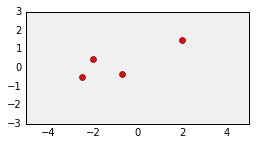

In [27]:
v = [-2.5, -2.0, -0.7, 2.0]
y_v = [-0.5, 0.5, -0.3, 1.5]
plt.figure(figsize=(4,2))
plt.ylim(-3, 3)
plt.xlim(-5, 5)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")

The standard approach to this problem is using regression: fitting a line or curve to the data and using it to predict all other values.

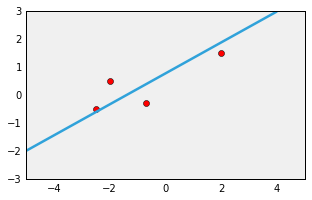

In [28]:
plt.figure(figsize=(5,3))
plt.ylim(-3, 3)
plt.xlim(-5, 5)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")
plt.plot([-5,4],[-2,3])

However, this gives us no indication of the level of uncertainty. What if we need to give a confidence level for each predicted point?

# The goal

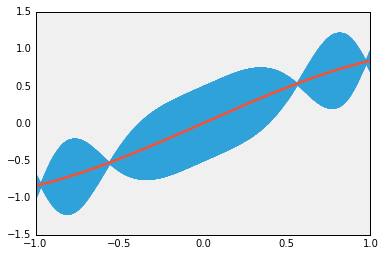

In [29]:
domain = np.arange(-1, 1, step=0.001)
values = [np.sin(x) for x in domain]
errors = [np.cos(5*x**2)*0.5 for x in domain]
plt.errorbar(domain, values, yerr=errors, capsize=0)
plt.plot(domain, values)

# Gaussian processes

The intuition behind Gaussian processes is: in the same way that you can have a Gaussian distribution over numbers or vectors, a Gaussian process is a distribution over functions.

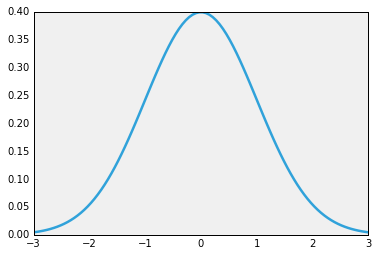

In [30]:
x = np.linspace(0-3*1,0+3*1, 100)
plt.plot(x,matplotlib.mlab.normpdf(x, 0, 1))
plt.show()

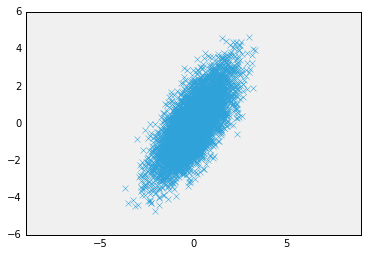

In [31]:
x, y = np.random.multivariate_normal([0,0], [[1,1],[1,2]], 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

Gaussian processes extend this idea to describe probability distributions over functions.

The key idea is to treat functions as members of a very high dimensional vector space, with each domain value $x_i$ corresponding to a different dimension. Then the function's definition is just a list of its values at each point. 

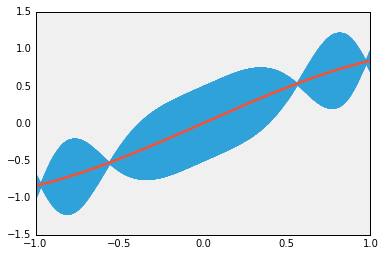

In [32]:
domain = np.arange(-1, 1, step=0.001)
values = [np.sin(x) for x in domain]
errors = [np.cos(5*x**2)*0.5 for x in domain]
plt.errorbar(domain, values, yerr=errors, capsize=0)
plt.plot(domain, values)

However, most truly "random" functions are very gnarly. Taking distributions over these would not give us anything useful.

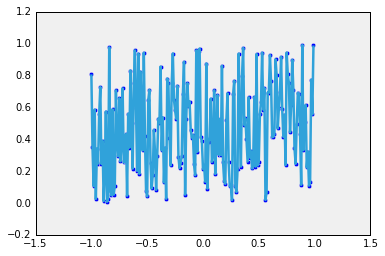

In [33]:
domain = np.arange(-1, 1, step=0.01)
values = [np.random.random() for x in domain]

# matplotlib.rcParams['lines.linewidth'] = 0.5
# matplotlib.rcParams['lines.linestyle'] = 'dotted'
plt.plot(domain, values)
plt.scatter(domain, values)

We can fix this by imposing some conditions on our random functions.

Recall that we are treating these functions as vectors over the space of the x-values. This gives us an analogy between the continuity of a random function and the covariance of a multivariate Gaussian distribution. Specifically, if the function is continuous, the covariance between dimensions representing neighbouring x-values will be close to one.

## The covariance function (kernel)

A common way to impose continuity is to use a squared exponential covariance.

$$\begin{aligned} \mu(u) &=0 \\ k(u,v) &= \theta_1\exp\left(-\frac{\theta_2}{2}(u - v)^2\right) \end{aligned}$$

In [34]:
def exponential_cov(u, v, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(u, v)**2)

Here is what the squared exponential looks like for a couple of values.

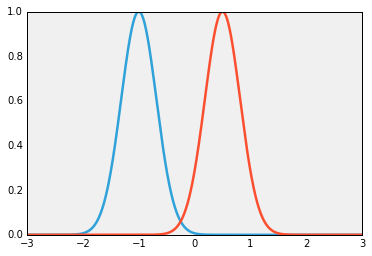

In [35]:
x_pred = np.linspace(-3, 3, 1000)
I = [1, 10]
plt.plot(x_pred, exponential_cov(-1.0, x_pred, I))
plt.plot(x_pred, exponential_cov(0.5, x_pred, I))

This covariance function approaches one when the input values are very similar, then drops away as the input values become more distinct. If we wished, we could use a different parameter to alter how quickly this happens.

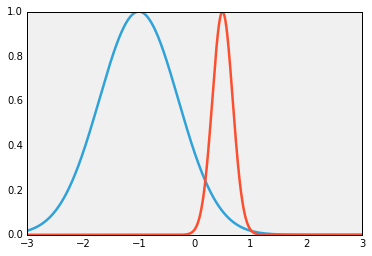

In [36]:
x_pred = np.linspace(-3, 3, 1000)
I = [1, 2]
plt.plot(x_pred, exponential_cov(-1.0, x_pred, I))
I = [1, 30]
plt.plot(x_pred, exponential_cov(0.5, x_pred, I))

This parameter corresponds to how quickly we expect our random function to change.

In [37]:
import GPy
import numpy as np

def sample(l):
    sample_size = 5
    X = np.random.uniform(0, 1., (sample_size, 1))
    Y = np.sin(X) + np.random.randn(sample_size, 1)*0.05

    kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=l)
    model = GPy.models.GPRegression(X,Y,kernel, noise_var=1e-2)

    testX = np.linspace(0, 1, 100).reshape(-1, 1)
    posteriorTestY = model.posterior_samples_f(testX, full_cov=True, size=1)
    simY, simMse = model.predict(testX)

    return hv.Curve([(testX[i], posteriorTestY[i]) for i in range(len(testX))])

sample(0.01) + sample(0.04) + sample(0.07)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
 /opt/conda/lib/python3.5/site-packages/GPy/core/gp.py:500: RuntimeWarning:covariance is not positive-semidefinite.
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


:Layout
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)

## Conditioning distributions

We can use the covariance to find the probability distribution of a point conditional on our current information.

$$p(u \mid v) = \mathcal{N}(\mu_u + \Sigma_{uv}\Sigma_v^{-1}(y_v-\mu_v), \Sigma_u-\Sigma_{uv}\Sigma_v^{-1}\Sigma_{uv}^T)$$

In [38]:
def conditional(u, v, y_v, kernel, params=[1, 10]):
    cov_u = kernel(u, u, params)
    cov_v = kernel(v, v, params)
    cov_uv = kernel(u, v, params)
    
    cov_v_inv = np.linalg.inv(cov_v)
    cov_T_uv = kernel(v, u, params)
    
    mu = cov_uv.dot(cov_v_inv).dot(y_v)
    sigma = cov_u - cov_uv.dot(cov_v_inv).dot(cov_T_uv)

    return(mu.squeeze(), sigma.squeeze())

This function takes in some known points, v, along with their values, y_v. The u parameter is the points we would like predictions for.

## Plotting the result

If we have values for points $v$, we can use our conditional function to constrain the values at other points in the domain. First, let's see what it looks like in the absence of prior information.

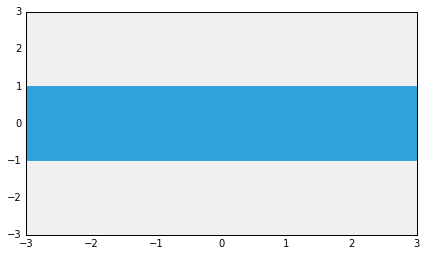

In [39]:
v = []
y_v = []

xpts = np.arange(-3, 3, step=0.01)
conds = [conditional(x, v, y_v, exponential_cov) for x in xpts]

plt.figure(figsize=(7,4))
plt.errorbar(xpts, [c[0] for c in conds], yerr=[c[1] for c in conds], capsize=0)
plt.ylim(-3, 3)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")

Every point has the same expected value and variance, reflecting our default expectations. We'll now add data for three observed points and see how this changes.

In [40]:
v = [-2.5, -2.0, -0.7, 2.0]
y_v = [-0.5, 0.5, -0.3, 1.5]

xpts = np.arange(-3, 3, step=0.01)
conds = [conditional(x, v, y_v, exponential_cov) for x in xpts]

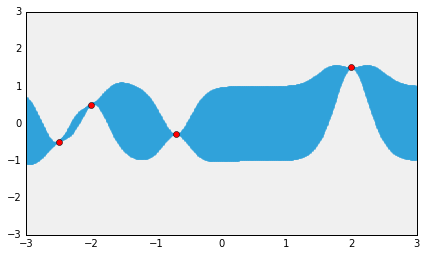

In [41]:
plt.figure(figsize=(7,4))
plt.errorbar(xpts, [c[0] for c in conds], yerr=[c[1] for c in conds], capsize=0)
plt.ylim(-3, 3)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")

The function is interpolated between the known values, giving a range of possibilities at each point. Using different parameter values in the covariance function will lead to quite different interpolations, as shown below.

In [ ]:
%opts Scatter style(color='red')

def plot_cov(p):
    covs = [(x, exponential_cov(0.0, x, [1,p])) for x in xpts]
    c = hv.Curve(covs)
    return c

def plot_gp(p):
    conds = [conditional(x, v, y_v, exponential_cov, params=[1, p]) for x in xpts]
    spread = hv.Spread((xpts, [c[0] for c in conds], [c[1] for c in conds]))
    return spread
        
dim_p = hv.Dimension('p', values=np.arange(1, 20).tolist())
pmap = hv.DynamicMap(plot_gp, kdims=[dim_p], label="Gaussian processes")
cmap = hv.DynamicMap(plot_cov, kdims=[dim_p], label="Gaussian processes")
cmap + (pmap * hv.Scatter(np.dstack((v, y_v))[0]))

The larger the value of p, the more quickly our certainty about the functions behaviour drops away. 

# Using GPy

In [43]:
import GPy

In [44]:
X = np.random.uniform(-3.,3.,(30,1))
Y = np.sin(5*X) + np.random.randn(30,1)*0.05 + X

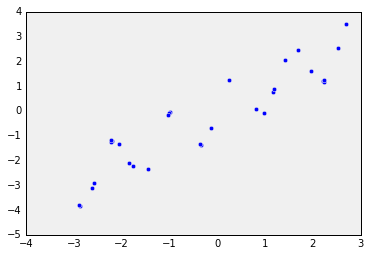

In [45]:
plt.scatter(X, Y)

In [46]:
rbf = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=0.5)
lin = GPy.kern.Linear(input_dim=1)

per = GPy.kern.Cosine(input_dim=1)

In [47]:
m = GPy.models.GPRegression(X, Y, rbf.add(lin), noise_var=1)
m.optimize_restarts(3)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Optimization restart 1/3, f = 2.6913832399411675
Optimization restart 2/3, f = 2.6913832393826667
Optimization restart 3/3, f = 38.64484118442763


 /opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


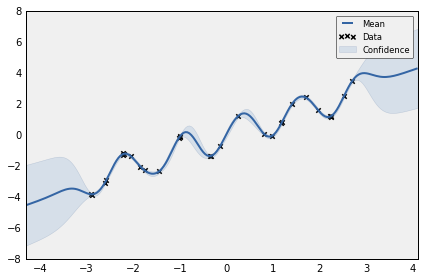

In [48]:
m.plot()